# Проект "Определение возраста покупателей"

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-необходимых-библиотек-для-анализа-данных" data-toc-modified-id="Загрузка-необходимых-библиотек-для-анализа-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка необходимых библиотек для анализа данных</a></span></li><li><span><a href="#Загрузка-исследуемых-данных" data-toc-modified-id="Загрузка-исследуемых-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка исследуемых данных</a></span></li><li><span><a href="#График-распределения-возраста-в-выборке" data-toc-modified-id="График-распределения-возраста-в-выборке-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>График распределения возраста в выборке</a></span></li><li><span><a href="#Вывод-одного-batch" data-toc-modified-id="Вывод-одного-batch-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Вывод одного batch</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели

## Постановка задачи

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.


Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Загрузка необходимых библиотек для анализа данных

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as p

### Загрузка исследуемых данных

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
data_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Всегдо в наборе 7591 промаркированная фотография.

In [5]:
features, target = next(data_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

В batch 3 цветовых канала, размеры изображений 224 на 224. 32 это количество изображений в batch.

In [7]:
target.shape

(32,)

32 целевых метки изображений в batch.

### График распределения возраста в выборке

In [13]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


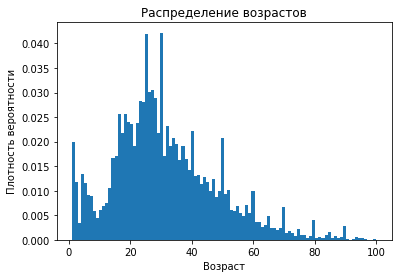

In [24]:
plt.hist(labels['real_age'], bins=100, density=True)
plt.xlabel('Возраст')
plt.ylabel('Плотность вероятности')
plt.title('Распределение возрастов')
plt.show()

Из графика видно, что в годах кратных 5 присутствуют аномалии (пики), т.о. имеет смысл предположение, что разметка изображений проводилась руками и возраст определялся не точно. Необходимо дать обратную связь тем, кто предоставил эти исходные данные.

In [12]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Распределение по возрастам неравномерное. Больше всего фотографий молодых людей от 20 до 30 лет. Учтем это при составлении обучающей выборки.

### Вывод одного batch

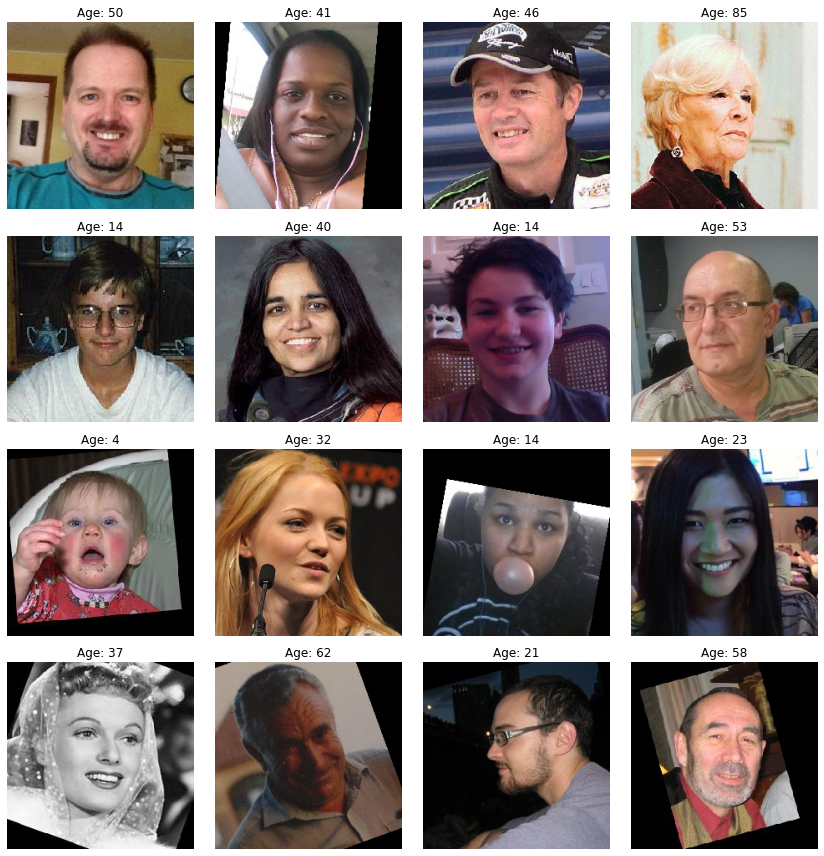

In [21]:
fig = plt.figure(figsize=(12, 12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title("Age: {}".format(target[i]))
    plt.axis('off')
    plt.tight_layout()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>Выводы по результатам исследовательского анализа датасета:

1) Представленный набор данных состоит из 7591 фотографии.
2) Целевой признак (возраст человека) распределен неравномерно. Большего всего изображений людей в возрасте от 20 до 30 лет. 50 % всех возрастов находятся в диапазоне от 20 до 41 года. Неравномерность распределения целевого признака по тренировочной выборки может привести к снижению точности модели.  Модель может быть склонна к предсказанию наиболее распространенного класса, даже если входные данные указывают на другой класс. Применим метод разделения фотографий по возрасту и выполним аугментацию для наименее представленных возрастных групп.
3) Датасет представляет собой набор файлов с фотографиями лиц людей. Каждый файл имеет уникальное имя - 000000.jpg, 000001.jpg итд. Обозначению каждой фотографии соответствует возраст из таблицы labels.csv.</b>

## Обучение модели

### Создание функций загрузки, модели и обучения

Обучение и выполнение предсказаний проводилось на отдельном сервере с GPU. Здесь представлен только код и результаты работы модели.

import pandas as pd
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error


def load_train(path):                                                              #функция загрузки обучающей выборки
    labels = pd.read_csv('/datasets/faces/labels.csv')

    elderly_datagen = ImageDataGenerator(rescale=1./255.,                           #генератор для возраста старше 50 лет
                                     horizontal_flip=True, 
                                     validation_split=0.25)

    elderly_gen_flow = elderly_datagen.flow_from_dataframe(dataframe=labels[labels['real_age'] >= 50], 
                                               directory=path + '/final_files',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='training',
                                               seed=42) 
    
    young_datagen = ImageDataGenerator(rescale=1./255.,                         #генератор для возраста младше 20 лет
                                     horizontal_flip=True, 
                                     validation_split=0.25)

    young_gen_flow = young_datagen.flow_from_dataframe(dataframe=labels[labels['real_age'] < 20],
                                               directory=path + '/final_files',
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=16,
                                               class_mode='raw',
                                               subset='training',
                                               seed=42)                                          

    main_datagen = ImageDataGenerator(rescale=1./255.,                         #генератор для среднего возраста
                                      horizontal_flip=True
                                      )

    main_gen_flow = main_datagen.flow_from_dataframe(dataframe=labels[labels['real_age'] < 50 and labels['real_age'] >= 20], 
                                                
                                            directory=path + '/final_files',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224, 224),
                                            batch_size=16,
                                            class_mode='raw',
                                            subset='training',
                                            seed=42) 

    train_data = itertools.chain(young_gen_flow, elderly_gen_flow, main_gen_flow)
    
    return train_data


def load_test(path):                                        #функция загрузки тестовой выборки
    df = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    
    test_data = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',  
        seed=42
    )
    
    return test_data


def create_model(input_shape):                          #создание модели на архитектуре ResNet50
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)              #топ создаем самостоятельно
    model = Sequential()
    model.add(backbone)
    optimizer = Adam(lr=0.0001)                       
    model.add(GlobalAveragePooling2D())                  #добавляем средний пулинг
    model.add(Dense(1, activation='relu'))               #слой с 1 нейроном и функцией активации relu
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  #loss функция MSE,метрика MAE
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

### Результаты работы модели

```

Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 50s - loss: 214.1180 - mae: 10.6924 - val_loss: 505.3835 - val_mae: 17.4036
Epoch 2/3
356/356 - 41s - loss: 66.8835 - mae: 6.3166 - val_loss: 182.5383 - val_mae: 10.0589
Epoch 3/3
356/356 - 41s - loss: 36.5262 - mae: 4.6436 - val_loss: 92.9540 - val_mae: 7.5264

119/119 - 10s - loss: 92.9540 - mae: 7.5264
Test MAE: 7.5264
```

Получившая метрика меньше требуемой МАЕ  = 8.

## Анализ обученной модели

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b>В проекте была построена и обучена сверточная нейронная сеть на датасете с фотографиями людей различных возрастов.
Нейронная сеть обучена для предсказания возраста человека по его фотографии. Была получена необходимая метрика МАЕ < 8.

Первоначально был проведен исследовательский анализ датасета. Было выявлено, что датасет состоит из 7591 фотографий. Распределение по возрасту неравномерное - больше всего людей в возрасте 20-30 лет. Это было учтено при формирование обучающей выборки. Для возрастов с меньшим представительством была выполнения аугментация.

За основу была взята сверточная нейронная сеть архитектуры ResNet50 с добавлением в Top GlobalAveragePooling2D и в связи с тем, что задача линейной регрессии - последнего слоя, состоящего из одного нейрона с функцией активации relu.

При значении learning rate = 0.0001 необходимое значение метрики достигается. Значение метрики составило 7.5.

С учетом полученных результатов можно рекомендовать использовать данную модель для выполнения первой поставленной задачи — анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы.
    
Что касается второй задачи — контролировать добросовестность кассиров при продаже алкоголя — с учетом полученного MAE, модель не покажет хороших результатов на практике.</b>
